# Trabajo: Eliminación de artefactos impulsivos en una imagen

<small>William Fabian Arevalo rodriguez</small>

![Median filter](https://upload.wikimedia.org/wikipedia/commons/a/ae/Median_filter_2D.gif)
Median Filter
<small><hr>Source https://commons.wikimedia.org/wiki/File:Median_filter_2D.gif</small>

In [1]:
# Import libraries
import numpy as np
import sklearn as sk
import skimage as ski
import matplotlib.pyplot as plt
import random
%matplotlib inline
print(f'numpy v.{np.__version__}\
\nsklearn v.{sk.__version__}\
\nskimage v.{ski.__version__}')

numpy v.1.18.1
sklearn v.0.22.1
skimage v.0.16.2


In [2]:
# Load a img
img = ski.data.astronaut()

Img shape (512, 512, 3)


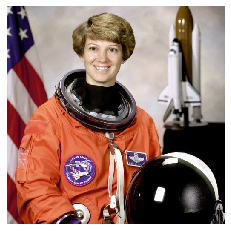

In [3]:
#Show img
plt.axis('off')
plt.imshow(img);
print(f'Img shape {img.shape}')

In [4]:
# Convert 3 channels to one channel rgb to gray
def rgbtogray(rgb_img):
    """Convert rgb image to grayscale image"""
    return np.dot(rgb_img[...,:3], [0.2989, 0.5870, 0.1140])

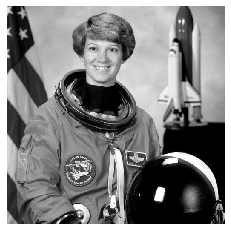

In [5]:
plt.axis('off')
plt.imshow(rgbtogray(img), cmap=plt.cm.gray);

Img shape (512, 512)


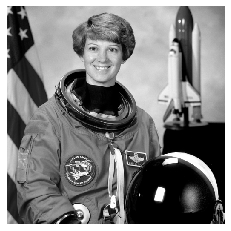

In [6]:
# Convert Color to gray (rgb2gray)
grays_img = ski.color.rgb2gray(img)
plt.axis('off')
plt.imshow(grays_img, cmap=plt.cm.gray);
print(f'Img shape {grays_img.shape}')

### 1. Crear una función que modele la adición, de forma aleatoria, de artefactos impulsivos. El resultado deberá apreciarse en la visualización de la imagen, que deberá estar afectada por ruido de tipo «sal y pimienta». Como se ha visto en la asignatura, estos artefactos toman valores de intensidad máximos o mínimos, y afectan, aleatoriamente, a los píxeles de la imagen. La función a implementar debe aceptar la imagen original y devolver la imagen afectada por el ruido. Además, sería deseable que aceptara un argumento adicional para indicar el porcentaje de píxeles que se verán afectados por estos artefactos. 

In [7]:
# Build a function for add noise(salt & pepper) to a img
def salt_pepper_noise(img, prob=None):
    """Add salt and pepper noise to a image
input:
img: image in 1D or Grayscale image
prob: Probability of noise float in range [0.01,0.09]
output:
return image with noise
"""
    output = np.zeros(img.shape, np.float32)
    if prob is None:
        prob = random.random() * 0.01
    thres = 1 - prob 
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            rdn = random.random()
            if rdn < prob:
                output[i][j] = 0
            elif rdn > thres:
                output[i][j] = 1
            else:
                output[i][j] = img[i][j]
    return output

In [8]:
# Build a function for add noise to a img
def add_noise(img, noise=None):
    """Add random noise
input:
img: 1d or 3d imagen
noise: float in range [0,1]
output:
return image with noise"""
    if noise is None:
        noise = random.random()*0.01
    return ski.util.random_noise(img, mode='s&p', amount=noise)

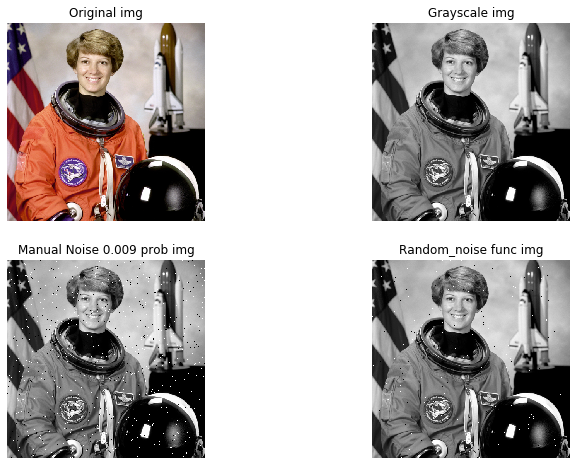

In [9]:
# Grid of img and transformations
plt.figure(figsize=(12,8))
# Original
plt.subplot(2,2,1)
plt.axis('off')
plt.title("Original img")
plt.imshow(img, cmap=plt.cm.gray)
# Gray
plt.subplot(2,2,2)
plt.axis('off')
plt.title("Grayscale img")
plt.imshow(grays_img, cmap=plt.cm.gray)
# Random Noise 1
plt.subplot(2,2,3)
plt.axis('off')
plt.title("Manual Noise 0.009 prob img")
plt.imshow(salt_pepper_noise(grays_img,0.009), cmap=plt.cm.gray)
# Random Noise 2
plt.subplot(2,2,4)
plt.axis('off')
plt.title("Random_noise func img")
plt.imshow(add_noise(grays_img), cmap=plt.cm.gray);

### A partir de la imagen ruidosa, buscaremos eliminar los artefactos impulsivos para el posterior tratamiento de la imagen. Para ello, se deberá aplicar un filtro adecuado para este tipo de ruido

In [10]:
# Import methods for denoise
from skimage.restoration import (denoise_tv_chambolle, denoise_bilateral,
                                 denoise_wavelet, estimate_sigma)

In [11]:
# Estimate the average noise standard deviation.
# Note : With multichannel in True is for rgb img
noise = 0.02
noisy_gray_img = salt_pepper_noise(grays_img, noise)
sigma_est = estimate_sigma(noisy_gray_img, multichannel=False, average_sigmas=True)
print(f'Real noise rate {noise} and estimated Gaussian noise {sigma_est:.3f} \
      \nMaybe gaussian is no the best because s&p is diff to gaussian method')

Real noise rate 0.02 and estimated Gaussian noise 0.019       
Maybe gaussian is no the best because s&p is diff to gaussian method


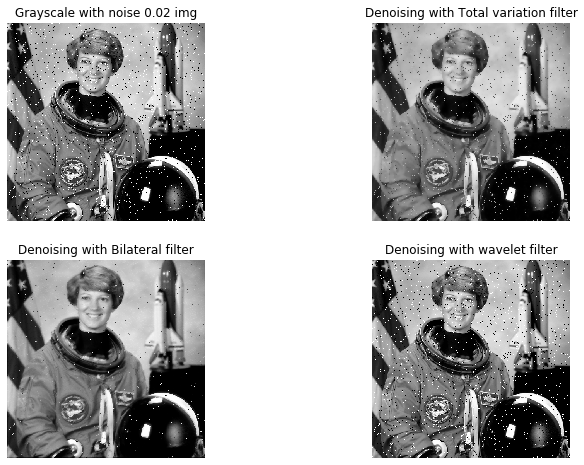

In [12]:
# Grid of methods for denoise Statistical
plt.figure(figsize=(12,8))
# Noise Gray
plt.subplot(2,2,1)
plt.axis('off')
plt.title(f"Grayscale with noise {noise} img")
plt.imshow(noisy_gray_img, cmap=plt.cm.gray)
# Total variation filter
plt.subplot(2,2,2)
plt.axis('off')
plt.title("Denoising with Total variation filter")
plt.imshow(denoise_tv_chambolle(noisy_gray_img), cmap=plt.cm.gray)
# Bilateral filter
plt.subplot(2,2,3)
plt.axis('off')
plt.title("Denoising with Bilateral filter")
plt.imshow(denoise_bilateral(noisy_gray_img), cmap=plt.cm.gray)
# Wavelet denoising filter
plt.subplot(2,2,4)
plt.axis('off')
plt.title("Denoising with wavelet filter")
plt.imshow(denoise_wavelet(noisy_gray_img, rescale_sigma=False), cmap=plt.cm.gray);

In [13]:
def manual_median_filter(img, offset=0, size_frame=3):
    """Apply Median filter
Input:
img: Imagen in 1D array like
offset: int near to 0 
size_frame: int near to 3 is good
output:
return a image with filter applied"""
    # Add offset
    size = (img.shape[0]+offset*2, img.shape[1]+offset*2)
    fig = np.zeros(size, np.float32)
    for i in range(size[0]-size_frame):
        for j in range(size[1]-size_frame):
            mid_i = (i+(size_frame // 2)) + 1
            mid_j = (j+(size_frame // 2)) + 1
            #tmp_list = img[i:i+size_frame,j:j+size_frame]
            fig[mid_i][mid_j] = np.median(img[i:i+size_frame,j:j+size_frame])

    return fig

/home/phoenix/anaconda3/lib/python3.7/site-packages/skimage/filters/rank/generic.py:119: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  out_dtype)


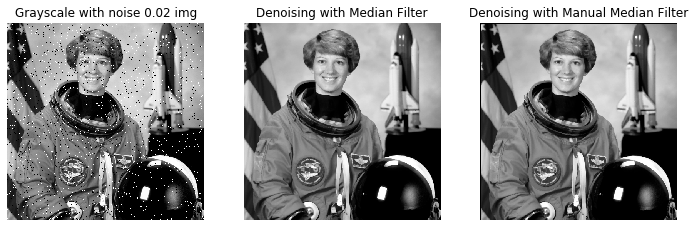

In [14]:
# Median filter
import skimage.filters as filters
from skimage.morphology import disk #this is for the size of the frame
# Grid of filters for denoise
plt.figure(figsize=(12,8))
# Noise Gray
plt.subplot(1,3,1)
plt.axis('off')
plt.title(f"Grayscale with noise {noise} img")
plt.imshow(noisy_gray_img, cmap=plt.cm.gray)
# Median filter
plt.subplot(1,3,2)
plt.axis('off')
plt.title("Denoising with Median Filter")
plt.imshow(filters.rank.median(noisy_gray_img), cmap=plt.cm.gray) # Frame of 3 pixels by default
# Manual Median filter
plt.subplot(1,3,3)
plt.axis('off')
plt.title("Denoising with Manual Median Filter")
plt.imshow(manual_median_filter(noisy_gray_img), cmap=plt.cm.gray);

### Por último, a partir de la imagen obtenida en la etapa anterior, se busca identificar las siluetas de las estructuras en ella presentes. Para este fin, se debe identificar y razonar qué tipo de operador corresponde aplicar.

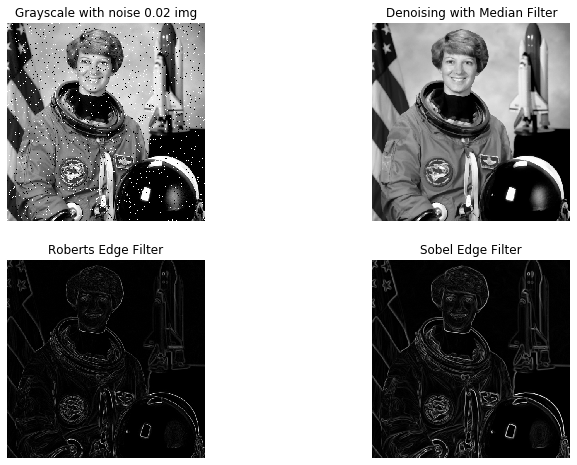

In [15]:
#Un filtro de borde es ideal(edges)
denoise_img = filters.rank.median(noisy_gray_img)
# Grid of edge filters
# Noise gray img
plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
plt.axis('off')
plt.title(f"Grayscale with noise {noise} img")
plt.imshow(noisy_gray_img, cmap=plt.cm.gray)
# Median filter
plt.subplot(2,2,2)
plt.axis('off')
plt.title("Denoising with Median Filter")
plt.imshow(denoise_img, cmap=plt.cm.gray) # Frame of 3 pixels by default
# Roberts Edge filter
plt.subplot(2,2,3)
plt.axis('off')
plt.title("Roberts Edge Filter")
plt.imshow(filters.roberts(denoise_img), cmap=plt.cm.gray)
# Sobel Edge filter
plt.subplot(2,2,4)
plt.axis('off')
plt.title("Sobel Edge Filter")
plt.imshow(filters.sobel(denoise_img), cmap=plt.cm.gray);


In [36]:
def edge_prewit_filter(img):
    #define the vertical filter
    #vertical_filter = [[-1,-2,-1], [0,0,0], [1,2,1]]
    vertical_filter = [[-1,-1,-1], [0,0,0], [1,1,1]]

    #define the horizontal filter
    horizontal_filter = [[-1,0,1], [-1,0,1], [-1,0,1]]

    #initialize the edges image
    edges_img = img.copy()

    #loop over all pixels in the image
    for row in range(3, n-2):
        for col in range(3, m-2):

            #create little local 3x3 box
            local_pixels = img[row-1:row+2, col-1:col+2]

            #apply the vertical filter
            vertical_transformed_pixels = vertical_filter*local_pixels
            #remap the vertical score
            vertical_score = vertical_transformed_pixels.sum()/4

            #apply the horizontal filter
            horizontal_transformed_pixels = horizontal_filter*local_pixels
            #remap the horizontal score
            horizontal_score = horizontal_transformed_pixels.sum()/4

            #combine the horizontal and vertical scores into a total edge score
            edge_score = (vertical_score**2 + horizontal_score**2)**.5

            #insert this edge score into the edges image
            edges_img[row, col] = edge_score

    #remap the values in the 0-1 range in case they went out of bounds
    return edges_img/edges_img.max()

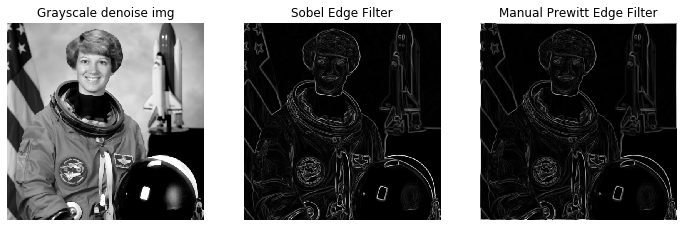

In [37]:
# Edge filter
# Grid of edge filters
plt.figure(figsize=(12,8))
# Denoising image
plt.subplot(1,3,1)
plt.axis('off')
plt.title(f"Grayscale denoise img")
plt.imshow(denoise_img, cmap=plt.cm.gray)
# Median filter
plt.subplot(1,3,2)
plt.axis('off')
plt.title("Sobel Edge Filter")
plt.imshow(filters.sobel(denoise_img), cmap=plt.cm.gray)
# Manual Median filter
plt.subplot(1,3,3)
plt.axis('off')
plt.title("Manual Prewitt Edge Filter")
plt.imshow(edge_prewit_filter(denoise_img), cmap=plt.cm.gray);

# End